In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np
from bertopic import BERTopic
from umap import UMAP
from transformers.pipelines import pipeline
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
import pandas as pd
from itertools import combinations
from collections import defaultdict, Counter
import math
import networkx as nx

d:\anaconda3\envs\test\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.25.4) or chardet (5.2.0)/charset_normalizer (None) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
d:\anaconda3\envs\test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#数据清洗
# #1. 读取CSV文件  
df = pd.read_csv('data/output-郑志.csv')  
  
# 第二列是'content'  
articles_tokens = df.iloc[:, 1].tolist()

# 读取同义词表并构建同义词替换字典
synonym_dict = {}
with open("data/synonyms.txt", "r", encoding="utf-8") as f:
    for line in f:
        synonyms = line.strip().split(",")
        for word in synonyms[1:]:
            synonym_dict[word] = synonyms[0]

# 替换同义词
for i in range(len(articles_tokens)):
    articles_tokens[i] = "/".join([synonym_dict.get(word, word) for word in articles_tokens[i].split("/")])

#轉化成列表
docs_pre=[] 
for article in articles_tokens:
    lines=article.split('/')
    chinese_words = [line for line in lines if line.strip()]
    docs_pre.append(chinese_words)

# 去除停用詞
stpwrd=open("data/stopwords-simple.txt","r",encoding='utf-8').read()
stop_words= stpwrd.split("\n")
sentences=[]
for words in docs_pre:
    doc = [token for token in words if token not in stop_words]
    docs_merge= " ".join(doc)
    sentences.append(docs_merge)

In [6]:
#加载预训练模型
model_name = "SIKU-BERT/sikubert"
model = BertModel.from_pretrained(model_name)

# 使用Tokenizer，就是为了将输入的句子加工为bert模型可以处理的格式
tokenizer = BertTokenizer.from_pretrained(model_name)

In [8]:
# 将模型放置在GPU上
device = torch.device("cuda")
# 把模型放到cpu或gpu
model.to(device)
# 将模型设置为评估模式，https://blog.csdn.net/weixin_45275599/article/details/131524189
model.eval()

# 切分数据
batch_size = 1  # 批大小
data_loader = DataLoader(sentences, batch_size=batch_size)
for batch in data_loader:
    print(len(batch), batch)

# 生成向量
cls_embeddings = []
for batch_sentences in tqdm(data_loader):# 使用tqdm显示处理进度
    inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embeddings.append(outputs.last_hidden_state[:, 0].cpu().numpy()) # 只取CLS对应的向量
    print('numpy格式', type(outputs.last_hidden_state[:, 0].cpu().numpy()), outputs.last_hidden_state[:, 0].cpu().numpy().shape)
# 合并文档向量
print('batch数：', len(cls_embeddings))
cls_embeddings_np = np.vstack(cls_embeddings)
print('文档向量', type(cls_embeddings_np), cls_embeddings_np.shape)

# 保存文档向量到npy文件
output_file = "data/embedding.npy"
np.save(output_file, cls_embeddings_np)
print("词向量存储于: ", output_file)
embeddings = np.load(output_file)
print("加载回来，验证一下：", type(embeddings), embeddings.shape)

#导入向量
embeddings = np.load('data/embedding.npy')
print(type(embeddings), embeddings.shape)

1 ['《 大畜 》 ‘ 六四 ， 童牛 之 梏 ， 元吉 ’ 。 注 ‘ 巽 為 木 ， 互體 震 。 震 為 牛 之 足 ， 足 在 艮 體 之 中 ， 艮 為 手 ， 持 木 以 就 足 ， 是 施 梏 ’ 。 又 《 蒙 》 ‘ 初六 ’ 注 ‘ 木 在 足 桎 ， 在 手 梏 ’ 。 今 《 大畜 》 ‘ 六四 ’ 施 梏 於 足 ， 不 審 桎 梏 、 手 足 定 有 別 否 ？ 牛 無 手 ， 故 以 足 言 之 。']
1 ['須 ， 才智 之 稱 ， 故 屈原 之 姊 以 為 名 。']
1 ['鄭 先師 以來 ， 皆 火 當 為 北 ， 當 黎 為 北正 。']
1 ['九州 而 八伯 者 何 ？ 畿 內 之 州 不 置 伯 ， 有 鄉遂 之 吏 主 之 。']
1 ['疑 而 鄭 按 《 左傳 》 ‘ 禹 會 諸侯 於 塗山 ， 執 玉帛 者 萬 國 ’ ， 《 外傳 》 ‘ 禹 朝 群臣 於 會稽 ， 防風氏 後 至 ’ ， 不 與 注 相 應 何 ？ 鄭 欲 明 諸侯 守土 之 祀 ， 故 兼用 外傳 、 內傳 語 。 不 達 鄭 旨 而 鄭 以 《 王制 》 論 之 ， 畿 內 之 國 有 百 里 、 有 七十 里 、 有 五十 里 。 今 率 以 下 等 計 之 ， 又 有 王城 、 關遂 、 郊郭 、 卿大夫 之 埰地 ， 數 不 在 中 。 今 就 四百 ， 似 頗 不 合 。 鄭 三代 異 物 ， 《 王制 》 之 法 ， 唐 虞 或 不 盡 然 。 堯 、 舜 之 德 ， 守 在 四 疆 ， 鄉遂 有 無 ， 無 以 言 也 。 公卿 大夫 有 田祿 者 ， 其 四百 國 ， 非 埰地 為 何 ？ 王城 之 大 ， 郊關 之 處 幾何 ？ 而 子 責 急 也 ？']
1 ['钜鹿 ， 今 名 廣河澤 。']
1 ['《 鄭志 》 說 貢篚 之 義 凡 所 貢篚 之 物 ， 皆 以 稅 物 市 之 ， 隨 時 物 價 ， 以 當 邦賦 。']
1 ['謂 河 在 兗州 之 北 已 分 為 九河 ， 分 而 復 合 ， 於 大陸 之 北 又 分 為 九 ， 故 之 《 禹貢 》 ‘ 導 河 至 於 大陸 ， 又 北 播 為 九河 ’ 。 然則 大陸 以 南 ， 固 未 播 也 。 在 於 兗州 ， 安 得 有 九 ？ 至 於 何 時

  1%|          | 2/175 [00:00<00:11, 14.87it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)


  2%|▏         | 4/175 [00:00<00:09, 17.29it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)


  7%|▋         | 12/175 [00:00<00:03, 42.35it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)


 16%|█▌        | 28/175 [00:00<00:01, 83.66it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)


 34%|███▎      | 59/175 [00:00<00:00, 122.43it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class '

 42%|████▏     | 74/175 [00:00<00:00, 127.70it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)


 50%|█████     | 88/175 [00:00<00:00, 129.28it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)


 58%|█████▊    | 102/175 [00:00<00:00, 127.01it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)


 68%|██████▊   | 119/175 [00:01<00:00, 138.12it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)


 76%|███████▌  | 133/175 [00:01<00:00, 136.08it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)


 85%|████████▌ | 149/175 [00:01<00:00, 141.98it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)


 94%|█████████▍| 165/175 [00:01<00:00, 145.11it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)
numpy格式 <class 'numpy.ndarray'> (1, 768)


100%|██████████| 175/175 [00:01<00:00, 119.11it/s]

numpy格式 <class 'numpy.ndarray'> (1, 768)
batch数： 175
文档向量 <class 'numpy.ndarray'> (175, 768)
词向量存储于:  data/embedding.npy
加载回来，验证一下： <class 'numpy.ndarray'> (175, 768)
<class 'numpy.ndarray'> (175, 768)


In [11]:
# 把模型放到cpu或gpu
model.to('cuda')  # 将模型加载到GPU
# 将模型设置为评估模式，https://blog.csdn.net/weixin_45275599/article/details/131524189
model.eval()

# 1. 词向量模型，同时加载本地训练好的词向量
embedding_model = pipeline(
  "feature-extraction",
  #model="JIHUAI/bert-ancient-chinese",device=0
  model="SIKU-BERT/sikubert",device=0
)

# 2. 创建UMAP降维模型
umap_model = UMAP(
  n_neighbors= 15,
  n_components=5,
  min_dist=0.0,
  metric='cosine',
  random_state=64
)
reduced_embeddings = umap_model.fit_transform(embeddings)


# 3. 创建HDBSCAN聚类模型
# 如果要建设离群值，可以减小下面两个参数min_cluster_size min_samples
# https://hdbscan.readthedocs.io/en/latest/faq.html
hdbscan_model = HDBSCAN(
  min_cluster_size=4,
  min_samples=5,
  metric='euclidean'
)


# 4. 创建CountVectorizer模型
stpwrd=open("data/stopwords.txt","r",encoding='utf-8').read()
stop_words= stpwrd.split("\n")
vectorizer_model =  TfidfVectorizer(token_pattern=r"(?u)\b\w+\b",max_df=0.95, min_df=2,stop_words=stop_words)

from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)


# 5. 选择主题表示
from bertopic.representation import MaximalMarginalRelevance

main_representation = MaximalMarginalRelevance(diversity=.5, top_n_words=30)
representation_model = {"Main": main_representation}

topic_model = BERTopic(
  embedding_model=embedding_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  min_topic_size=4, 
  verbose=True,
)

# 训练模型
topic_model.fit_transform(sentences, embeddings=embeddings)

# 获取聚类结果
topic_info = topic_model.get_topic_info()

#保存聚类结果
topic_docs = topic_model.get_document_info(sentences)
topic_docs.to_csv('data/聚类结果n=6.csv')

# ⭐ UMAP可视化
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine',random_state=64).fit_transform(embeddings)
topic_model.visualize_documents(sentences,  reduced_embeddings=reduced_embeddings)

2024-07-27 09:33:31,449 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-27 09:33:32,148 - BERTopic - Dimensionality - Completed ✓
2024-07-27 09:33:32,149 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-27 09:33:32,154 - BERTopic - Cluster - Completed ✓
2024-07-27 09:33:32,158 - BERTopic - Representation - Extracting topics from clusters using representation models.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
2024-07-27 09:33:33,753 - BERTopic - Representation - Completed ✓


In [14]:
# 把模型放到cpu或gpu
model.to('cuda')  # 将模型加载到GPU
# 将模型设置为评估模式，https://blog.csdn.net/weixin_45275599/article/details/131524189
model.eval()

# 1. 词向量模型，同时加载本地训练好的词向量
embedding_model = pipeline(
  "feature-extraction",
  #model="JIHUAI/bert-ancient-chinese",device=0
  model="SIKU-BERT/sikubert",device=0
)

# 2. 创建UMAP降维模型
umap_model = UMAP(
  n_neighbors= 15,
  n_components=5,
  min_dist=0.0,
  metric='cosine',
  random_state=64
)
reduced_embeddings = umap_model.fit_transform(embeddings)


# 3. 创建HDBSCAN聚类模型
# 如果要建设离群值，可以减小下面两个参数min_cluster_size min_samples
# https://hdbscan.readthedocs.io/en/latest/faq.html
hdbscan_model = HDBSCAN(
  min_cluster_size=4,
  min_samples=4,
  metric='euclidean'
)


# 4. 创建CountVectorizer模型
stpwrd=open("data/stopwords.txt","r",encoding='utf-8').read()
stop_words= stpwrd.split("\n")
vectorizer_model =  TfidfVectorizer(token_pattern=r"(?u)\b\w+\b",max_df=0.95, min_df=2,stop_words=stop_words)

from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)


# 5. 选择主题表示
from bertopic.representation import MaximalMarginalRelevance

main_representation = MaximalMarginalRelevance(diversity=.5, top_n_words=30)
representation_model = {"Main": main_representation}

topic_model = BERTopic(
  embedding_model=embedding_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  min_topic_size=4, 
  verbose=True,
)

# 训练模型
topic_model.fit_transform(sentences, embeddings=embeddings)

# 获取聚类结果
topic_info = topic_model.get_topic_info()

#保存聚类结果
topic_docs = topic_model.get_document_info(sentences)
topic_docs.to_csv('data/聚类结果n=10.csv')

# ⭐ UMAP可视化
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine',random_state=64).fit_transform(embeddings)
topic_model.visualize_documents(sentences,  reduced_embeddings=reduced_embeddings)

2024-07-27 09:34:58,744 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-27 09:34:59,421 - BERTopic - Dimensionality - Completed ✓
2024-07-27 09:34:59,422 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-27 09:34:59,426 - BERTopic - Cluster - Completed ✓
2024-07-27 09:34:59,427 - BERTopic - Representation - Extracting topics from clusters using representation models.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
2024-07-27 09:35:01,755 - BERTopic - Representation - Completed ✓


In [15]:
topic_model.visualize_barchart(top_n_topics=20, n_words=10,width=400, height=600)

In [17]:
# 把模型放到cpu或gpu
model.to('cuda')  # 将模型加载到GPU
# 将模型设置为评估模式，https://blog.csdn.net/weixin_45275599/article/details/131524189
model.eval()

# 1. 词向量模型，同时加载本地训练好的词向量
embedding_model = pipeline(
  "feature-extraction",
  #model="JIHUAI/bert-ancient-chinese",device=0
  model="SIKU-BERT/sikubert",device=0
)

# 2. 创建UMAP降维模型
umap_model = UMAP(
  n_neighbors= 15,
  n_components=5,
  min_dist=0.0,
  metric='cosine',
  random_state=64
)
reduced_embeddings = umap_model.fit_transform(embeddings)


# 3. 创建HDBSCAN聚类模型
# 如果要建设离群值，可以减小下面两个参数min_cluster_size min_samples
# https://hdbscan.readthedocs.io/en/latest/faq.html
hdbscan_model = HDBSCAN(
  min_cluster_size=4,
  min_samples=3,
  metric='euclidean'
)


# 4. 创建CountVectorizer模型
stpwrd=open("data/stopwords.txt","r",encoding='utf-8').read()
stop_words= stpwrd.split("\n")
vectorizer_model =  TfidfVectorizer(token_pattern=r"(?u)\b\w+\b",max_df=0.95, min_df=2,stop_words=stop_words)

from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)


# 5. 选择主题表示
from bertopic.representation import MaximalMarginalRelevance

main_representation = MaximalMarginalRelevance(diversity=.5, top_n_words=30)
representation_model = {"Main": main_representation}

topic_model = BERTopic(
  embedding_model=embedding_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  min_topic_size=4, 
  verbose=True,
)

# 训练模型
topic_model.fit_transform(sentences, embeddings=embeddings)

# 获取聚类结果
topic_info = topic_model.get_topic_info()

#保存聚类结果
topic_docs = topic_model.get_document_info(sentences)
topic_docs.to_csv('data/聚类结果n=15.csv')

# ⭐ UMAP可视化
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine',random_state=64).fit_transform(embeddings)
topic_model.visualize_documents(sentences,  reduced_embeddings=reduced_embeddings)

2024-07-27 09:35:42,104 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-27 09:35:43,017 - BERTopic - Dimensionality - Completed ✓
2024-07-27 09:35:43,019 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-27 09:35:43,023 - BERTopic - Cluster - Completed ✓
2024-07-27 09:35:43,024 - BERTopic - Representation - Extracting topics from clusters using representation models.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
2024-07-27 09:35:46,278 - BERTopic - Representation - Completed ✓


In [18]:
hierarchical_topics = topic_model.hierarchical_topics(sentences)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 14/14 [00:02<00:00,  4.89it/s]


In [21]:
# Run the visualization with the original embeddings
topic_model.visualize_hierarchical_documents(sentences, hierarchical_topics, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine',random_state=64).fit_transform(embeddings)
fig=topic_model.visualize_hierarchical_documents(sentences, hierarchical_topics, reduced_embeddings=reduced_embeddings)
fig.write_html("data/hierarchical_documents.html")

C:\Users\11143\AppData\Local\Temp\ipykernel_8064\995866135.py:36: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



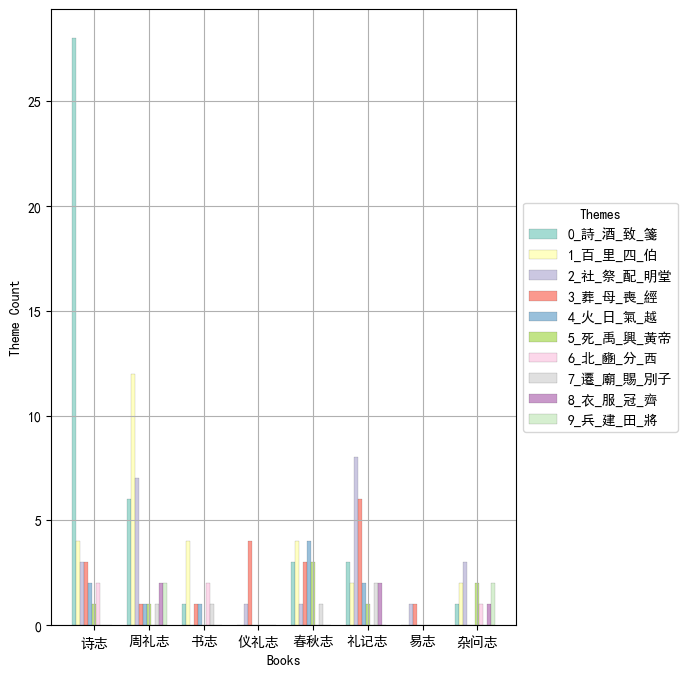

In [22]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取CSV文件  
df = pd.read_csv('data/聚类结果n=10.csv')  
sentences = df['Document'].tolist()
themes = df['Topic'].tolist()
theme_names = df['Name'].tolist()

with open('data/book-name.txt', "r", encoding='utf-8') as file:
    labels = [line.strip() for line in file.readlines()]

# 找到所有唯一的主题和标签
unique_themes = list(set(themes))
unique_labels = list(set(labels))

# 创建一个嵌套字典来计数
theme_label_count = defaultdict(lambda: defaultdict(int))

# 统计每个label下每个主题的数量
for theme, label in zip(themes, labels):
    theme_label_count[theme][label] += 1

# 为每个主题准备数据
plot_data = {theme: [theme_label_count[theme][label] for label in unique_labels] for theme in unique_themes}

# 绘制柱形图
plt.figure(figsize=(6, 8))
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 使用颜色字典来保存每个主题的颜色
colors = plt.cm.get_cmap('Set3', len(unique_themes))

# 设置柱子的宽度
bar_width = 0.8 / len(unique_themes)

# 绘制每个主题的柱形图并保存每个主题的柱形对象和名称
bars = []
labels_for_legend = []
theme_name_map = dict(zip(unique_themes, theme_names))  # 主题到主题名称的映射

# 使用 numpy 来创建位置
indices = np.arange(len(unique_labels))

for idx, theme in enumerate(unique_themes):
    if theme > -1:
        counts = plot_data[theme]
      # 仅绘制非零数量的主题
        if any(counts):  # 仅绘制非零数量的主题
            bar = plt.bar(indices + idx * bar_width, counts, bar_width, label=theme_name_map[theme], color=colors(idx), alpha=0.8, linewidth=0.1, edgecolor='black')
            bars.append(bar)
            labels_for_legend.append(theme_name_map[theme])

# 绘制每个主题的折线并保存每个主题的线条对象和名称
#lines = []
labels_for_legend = []
theme_name_map = dict(zip(themes, theme_names))  # 主题到主题名称的映射

for idx, theme in enumerate(unique_themes):
    if theme > -1:  # 仅绘制非零数量的主题
        counts = plot_data[theme]
        if any(counts):  # 仅绘制非零数量的主题
            labels_for_legend.append(theme_name_map[theme])

plt.xlabel('Books')
plt.ylabel('Theme Count')
#plt.title('Theme Count by Labels')

# 设置 x 轴刻度
plt.xticks(indices + bar_width * (len(unique_themes) / 2 - 0.5), unique_labels)

# 设置图例在右侧
plt.legend(bars, labels_for_legend, title='Themes', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

In [ ]:
#构建语义相似度矩阵

# 读取同义词表并构建同义词替换字典
synonym_dict = {}
with open("synonyms.txt", "r", encoding="utf-8") as f:
    for line in f:
        synonyms = line.strip().split("\t")
        for word in synonyms[0:]:
            synonym_dict[word] = synonyms[1]

# 替换同义词
for i in range(len(tokens1)):
    tokens1[i] = "/".join([synonym_dict.get(word, word) for word in tokens1[i].split("/")])



#轉化成列表
docs_pre=[] 
for article in tokens1:
    article_tokens=article.split('/')
    lines= [re.sub(r'[^\w\s]', '', seg) for seg in article_tokens]
    chinese_words = [line for line in lines if line.strip()]
    docs_pre.append(chinese_words)

# 去除停用詞
stpwrd=open("data/stopwords.txt","r",encoding='utf-8').read()
stop_words= stpwrd.split("\n")

docs=[]
for words in docs_pre:
    doc = [token for token in words if token not in stop_words]
    docs.append(doc)   

# 训练 word2vec 模型
model2 = word2vec.Word2Vec(docs, vector_size=300,window=5, min_count=3, workers=12,epochs=64)
vocab_pre = list(model2.wv.index_to_key) 
print("禮：",model2.wv.most_similar('禮', topn=20))
with open("./coreword.txt","r",encoding='utf-8') as f:
    words_core = [line.strip() for line in f.readlines()]
with open("./target.txt","r",encoding='utf-8') as f:
    words_target = [line.strip() for line in f.readlines()]
    
vocab_dlc=list(words_core + vocab_pre)
docs_new=[]
for words in docs:
    doc = [token for token in words if token in vocab_dlc]
    docs_new.append(doc)   

model = word2vec.Word2Vec(docs_new, vector_size=300,window=9, min_count=1, workers=12,epochs=72)

# # 保存模型
# model.save('word2vec_1.model')
# # # 加载模型
# model = Word2Vec.load('word2vec_1.model') 

# 将所有词转化成词向量并建立词典
word_vectors = []
word2ind = {}
for i, word in enumerate(word_tokens):
    word_vectors.append(model.wv[word])
    word2ind[word] = i
word_vectors = np.array(word_vectors)

words_list=[]
for target_word in words_core:
    similar_words =  [word for word, _ in model.wv.most_similar(target_word, topn=10)]
    words_list.append(similar_words)
words_dlc_pre=[token for sentence in words_list for token in sentence]
words_dlc = list(set(words_dlc_pre))
vocab=[token for token in words_dlc if token in vocab_pre]

merged_list = list(set(words_core + vocab))

# 创建一个空的相似性矩阵
similarity_matrix = np.zeros((len(merged_list ), len(merged_list )))

# 计算每两个词之间的相似性
for i in range(len(merged_list)):
        for j in range(len(merged_list)):
                similarity_matrix[i][j] = model.wv.similarity(merged_list[i], merged_list[j])
        

# 将相似性矩阵转换为DataFrame
df_similarity = pd.DataFrame(similarity_matrix, index=merged_list , columns=merged_list )


# 将相似度大于0.5的值设置为NaN
df_similarity_new = df_similarity*1
df_similarity_new[df_similarity_new  <= 0.75] = np.nan
df_similarity_new[df_similarity_new  >= 0.99] = np.nan


# 将相似度大于0.5的值设置为NaN
df_similarity_new = df_similarity*0.2
df_similarity_new[df_similarity_new  <= 0.12] = np.nan

# 保存DataFrame到CSV文件
df_similarity_new.to_csv("data/word_similarity_matrix.csv")